<a href="https://colab.research.google.com/github/Artuiro-23/Walmart_Sparkathon/blob/main/walmart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Assuming your dataset is in a CSV file
data = pd.read_csv('sales_data.csv')

# Convert 'Order Date' to datetime
data['Order Date'] = pd.to_datetime(data['Order Date'], format='%d-%m-%Y %H:%M')

# Set 'Order Date' as the index
data.set_index('Order Date', inplace=True)

# Group by 'Order Date' and 'Product', then sum the 'Quantity Ordered' to get the total quantity sold per product per date
grouped_data = data.groupby(['Order Date', 'Product']).sum()['Quantity Ordered']

# Unstack the product column to get a time-series for each product
product_data = grouped_data.unstack().fillna(0)

print(product_data.head())


Product              20in Monitor  27in 4K Gaming Monitor  27in FHD Monitor  \
Order Date                                                                    
2019-02-01 08:25:00           0.0                     0.0               0.0   
2019-02-01 08:30:00           0.0                     0.0               0.0   
2019-02-01 09:18:00           0.0                     0.0               0.0   
2019-02-01 09:26:00           0.0                     0.0               0.0   
2019-02-01 09:54:00           0.0                     0.0               0.0   

Product              34in Ultrawide Monitor  AA Batteries (4-pack)  \
Order Date                                                           
2019-02-01 08:25:00                     0.0                    0.0   
2019-02-01 08:30:00                     0.0                    0.0   
2019-02-01 09:18:00                     0.0                    0.0   
2019-02-01 09:26:00                     0.0                    0.0   
2019-02-01 09:54:00       

In [ ]:
# Resample the data to weekly frequency and sum the quantities for each week
weekly_product_data = product_data.resample('W').sum()

# Display the first few rows of the weekly resampled dataframe
print("Weekly Product Data:")
print(weekly_product_data.head())


Weekly Product Data:
Product     20in Monitor  27in 4K Gaming Monitor  27in FHD Monitor  \
Order Date                                                           
2019-02-03           3.0                     6.0               4.0   
2019-02-10           6.0                    13.0              13.0   
2019-02-17           5.0                    10.0              17.0   
2019-02-24           8.0                    10.0              17.0   
2019-03-03           5.0                     8.0               4.0   

Product     34in Ultrawide Monitor  AA Batteries (4-pack)  \
Order Date                                                  
2019-02-03                     3.0                   19.0   
2019-02-10                    17.0                   52.0   
2019-02-17                    16.0                   59.0   
2019-02-24                    16.0                   63.0   
2019-03-03                     2.0                   37.0   

Product     AAA Batteries (4-pack)  Apple Airpods Headphones

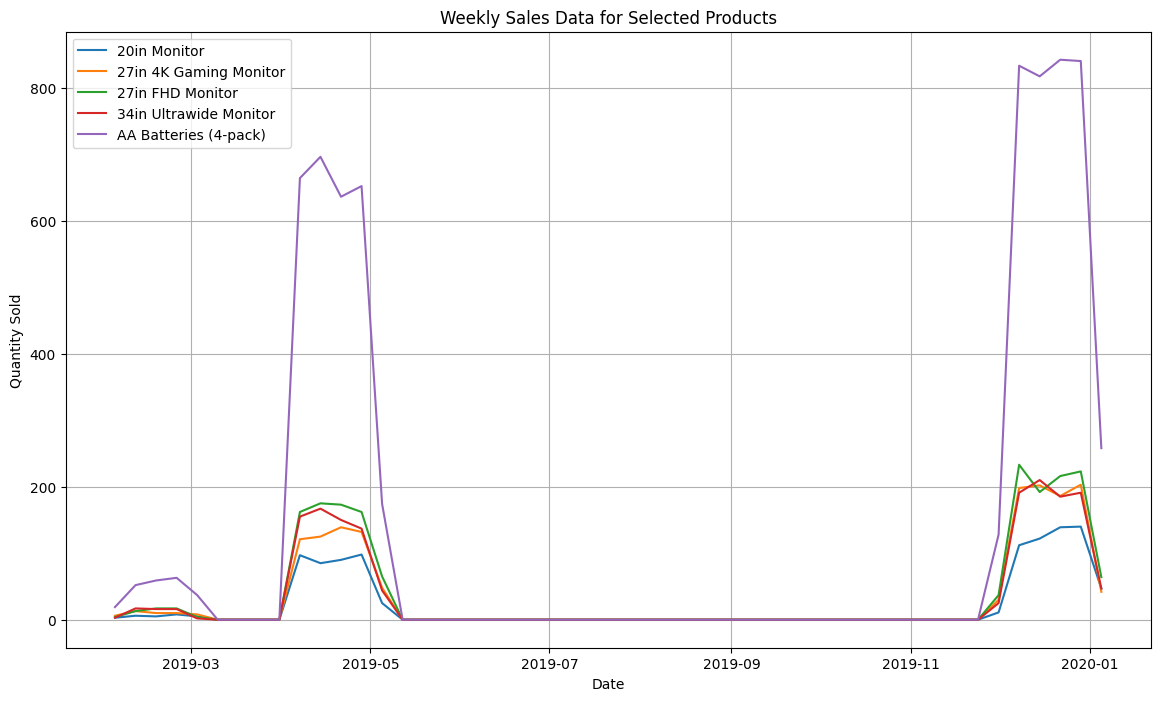

In [ ]:
import matplotlib.pyplot as plt

# Plot the weekly data for a few products
plt.figure(figsize=(14, 8))
for product in weekly_product_data.columns[:5]:  # Plot for the first 5 products as an example
    plt.plot(weekly_product_data.index, weekly_product_data[product], label=product)

plt.title('Weekly Sales Data for Selected Products')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split


# Define the target column and features
target_column = 'LG Dryer'  # Example target column
X = weekly_product_data.drop(columns=[target_column])
y = weekly_product_data[target_column]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and fit the Lasso model
lasso = Lasso(alpha=0.5, max_iter=20000)
lasso.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lasso = lasso.predict(X_test_scaled)

# Evaluate the model
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f'Lasso Regression MSE: {mse_lasso}')


Lasso Regression MSE: 8.521478973740924


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize and fit the Gradient Boosting model
gbr = GradientBoostingRegressor(n_estimators=100)
gbr.fit(X_train, y_train)

# Make predictions
y_pred_gbr = gbr.predict(X_test)

# Evaluate the model
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
print(f'Gradient Boosting MSE: {mse_gbr}')


Gradient Boosting MSE: 7.03835852265094


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load your weekly data
# Assuming weekly_product_data is a DataFrame with 'Order Date' as index and product columns
# Example: weekly_product_data = pd.read_csv('weekly_product_data.csv', parse_dates=['Order Date'], index_col='Order Date')

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(weekly_product_data)

# Convert to DataFrame
scaled_data_df = pd.DataFrame(scaled_data, columns=weekly_product_data.columns, index=weekly_product_data.index)

# Define a function to create sequences for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Set sequence length (e.g., 4 weeks)
seq_length = 4

# Create sequences
X, y = create_sequences(scaled_data_df.values, seq_length)


In [ ]:
from sklearn.model_selection import train_test_split

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, X.shape[2]), return_sequences=True),
    LSTM(50, activation='relu'),
    Dense(y.shape[1])
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=1)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 412ms/step - loss: 0.0645 - val_loss: 8.7857e-06
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0646 - val_loss: 3.8927e-05
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0531 - val_loss: 9.0986e-05
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0622 - val_loss: 1.7059e-04
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0419 - val_loss: 2.6671e-04
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0601 - val_loss: 3.9679e-04
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0593 - val_loss: 5.6473e-04
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0594 - val_loss: 7.7514e-04
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0683 - val_loss: 0.0010
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0472 - val_loss: 0.0013
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0654 - val_loss: 0.0016
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.055

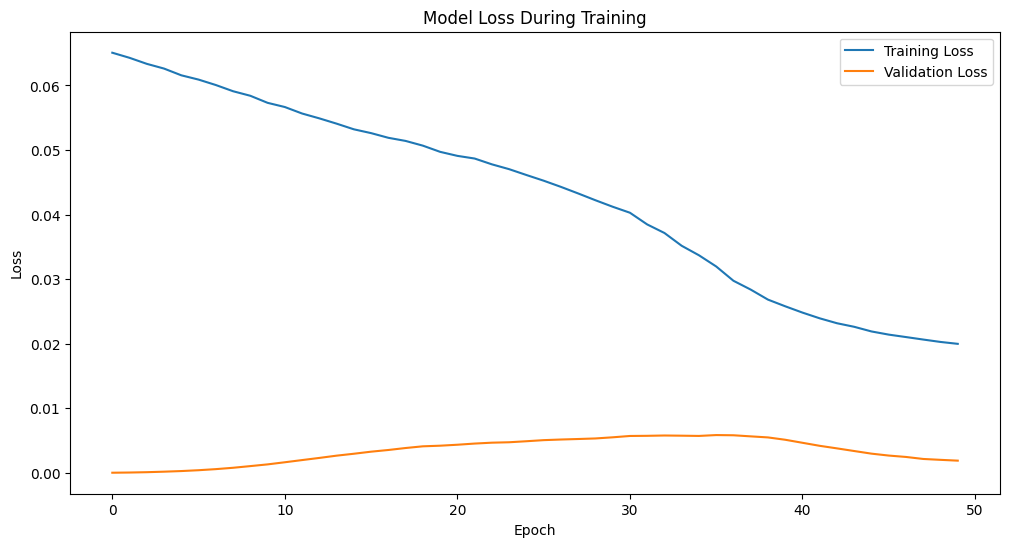

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming y_test and y_pred are 1D arrays of true values and predictions respectively

# # Calculate MSE
# mse = mean_squared_error(y_test, y_pred)
# print(f"LSTM MSE: {mse}")

# # Calculate MAE
# mae = mean_absolute_error(y_test, y_pred)
# print(f"LSTM MAE: {mae}")

# # Calculate R-squared
# r2 = r2_score(y_test, y_pred)
# print(f"LSTM R-squared: {r2}")

# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


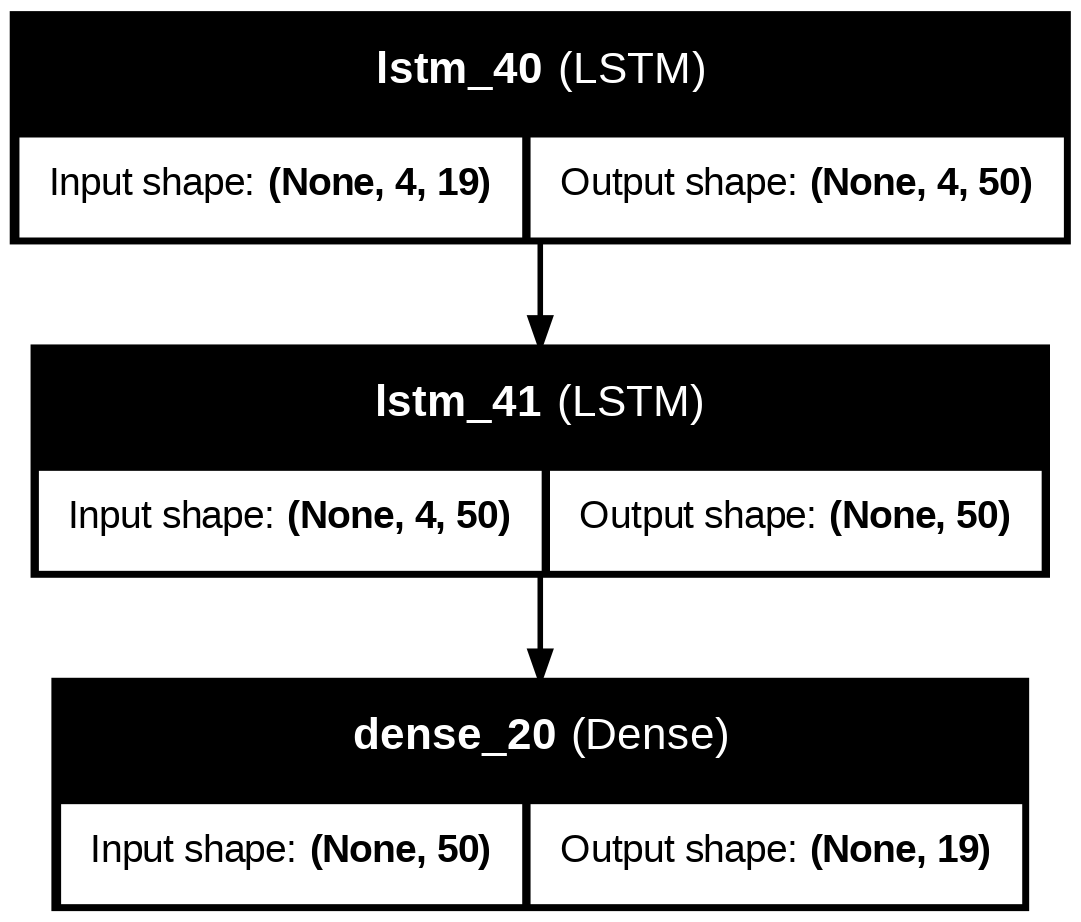

In [ ]:
from tensorflow.keras.utils import plot_model

# Assuming `model` is your LSTM model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
